# Table of Content

- <a href='#Introduction'> 1. Introduction </a>
- <a href='#Libs'> 2. Importing the Libraries </a>
- <a href='#Data'> 3. Importing the Dataset </a>
- <a href='#feature_selection'> 4. Feature Selection </a>
    - <a href='#categorical_variables'> 4.1 Categorical variables </a>
    - <a href='#numerical_variables'> 4.2 Numerical variables </a>
    - <a href='#final_selection'> 4.3 Final Feature Selection </a>
- <a href='#feature_encoding'> 5. Feature Encoding </a>
    - <a href='#label_encoding'> 5.1 Label Encoding </a>
    - <a href='#one_hot'> 5.2 One-Hot Encoding </a>
- <a href='#train_test'> 6. Splitting the dataset into the Training set and Test set </a>
- <a href='#feature_scaling'> 7. Feature Scaling </a>
- <a href='#modelling'> 8. Modelling </a>
- <a href='#hyperparameter'> 9. Hyperparameter tuning </a>
- <a href='#final_model'> 10. Final Model </a>

<a id='Introduction'></a>
# 1. Introduction

Telecom **Customer Churn** refers to the situation where customers stop using the services of a telecom company, either by switching to a competitor or by discontinuing the service altogether. Churn is a significant problem for telecom companies as it not only leads to a loss of revenue but also affects their reputation and market share. Identifying the reasons for customer churn and taking steps to prevent it is crucial for telecom companies to retain their customers and maintain their market position. 

Based on the previous analysis we are going to use particular **machine learning techniques** to **predict if customer is likely to churn or not**.

<a id='Libs'></a>
# 2. Importing the Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)

# Setting this option will print all rows of a dataframe
pd.set_option('display.max_rows', None)

# Setting this option will print all collumns of a numpy array
import sys
np.set_printoptions(threshold=sys.maxsize)

<a id='Data'></a>
# 3. Importing the Dataset

In [7]:
data = pd.read_csv('churn.csv')
X = data.iloc[:,:-1]  
y = data.iloc[:,-1].map({'Churned': 1, 'Stayed':0})    

<a id='feature_selection'></a>
# 4. Feature Selection

In [9]:
# divide columns to categorical and numerical 
categorical_columns = X.select_dtypes(['object']).columns
numerical_columns = X.select_dtypes(['number']).columns

<a id='categorical_variables'></a>
## 4.1 Categorical variables

### Mutual Information

Mutual information between two random variables is a non-negative value, which **measures the mutual dependency between the variables** based on entropy estimations. In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the target (response) variable.

Mutual information is equal to **zero if and only if two random variables are independent**. **Higher values mean higher dependency**, which indicates that the independent variable will be useful for predicting the target.

In [12]:
# transform all categorical variables to numeric, required for mutual_info_classif and .cat.codes 

# convert them to category types
X[categorical_columns] = X[categorical_columns].apply(lambda x: x.astype('category'))

# transform them to numeric columns 
X[categorical_columns] = X[categorical_columns].apply(lambda x: x.cat.codes)

In [13]:
# mutual_info_classif - estimate mutual information for a discrete target variable
from sklearn.feature_selection import mutual_info_classif
mutual_info = pd.Series(mutual_info_classif(X[categorical_columns], y))
mutual_info.index = X.columns.intersection(categorical_columns)
mutual_info.sort_values(ascending=False)

Contract                  0.151122
Premium Tech Support      0.076657
Online Security           0.062201
Offer                     0.060198
Internet Type             0.049680
Device Protection Plan    0.044847
Online Backup             0.043540
Streaming Music           0.031893
Internet Service          0.030472
Streaming Movies          0.030009
Streaming TV              0.027352
Payment Method            0.024210
Unlimited Data            0.022239
Paperless Billing         0.018545
Married                   0.015049
Multiple Lines            0.000000
Phone Service             0.000000
Gender                    0.000000
dtype: float64

### SelectKBest

Selects the features according to the k highest scores computed by provided function. In this case we provide **chi2** function, select **all features** and **reorder** them according to their scores **in descending order**. 

In [15]:
from sklearn.feature_selection import SelectKBest, chi2
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X[categorical_columns],y)
best_features = pd.Series(fit.scores_)
best_features.index = X.columns.intersection(categorical_columns)
best_features.sort_values(ascending=False)

Contract                  1410.955820
Online Security            591.737438
Premium Tech Support       562.569180
Offer                      309.680506
Online Backup              262.006146
Device Protection Plan     229.244382
Married                    109.869893
Paperless Billing           92.132055
Payment Method              79.030251
Internet Service            67.509142
Streaming Music             29.858023
Streaming Movies            17.467149
Streaming TV                16.216424
Unlimited Data              13.849898
Internet Type                6.848586
Multiple Lines               0.567943
Gender                       0.133089
Phone Service                0.132963
dtype: float64

Comparing the results of mutual information and SelectKBest methods, we can see that the first three and the last three features are the same in both cases.

Based on above, we are going to drop following features: **Gender , Multiple Lines , Phone Service**

<a id='numerical_variables'></a>
## 4.2 Numerical variables

Now, we are going to check the mutual dependency between every numerical feature and the target feature. Also we need to check the correlation between the numerical variables themselves to choose the features:
 - that are highly correlated with the target,  and
 - are low correlated between each other


### Mutual Information

In [19]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = pd.Series(mutual_info_classif(X[numerical_columns], y))
mutual_info.index = X.columns.intersection(numerical_columns)
mutual_info.sort_values(ascending=False)

Tenure in Months                     0.174213
Total Revenue                        0.097596
Total Charges                        0.093111
Total Long Distance Charges          0.087478
Number of Referrals                  0.081691
Number of Dependents                 0.052014
Monthly Charge                       0.048396
Avg Monthly GB Download              0.037816
Age                                  0.016879
Total Refunds                        0.007653
Avg Monthly Long Distance Charges    0.007598
Total Extra Data Charges             0.004427
dtype: float64

###  Correlation

For evaluation of correlation we can choose one of the following methods: 
- **pearson** - measures the **linear** correlation between the two variables. It is the ratio between the covariance of two variables and the product of their standard deviations; 
- **kendall** - measures the **ordinal** association between the two measured quantities;
- **spearman** - assesses how well the relationship between two variables can be described using a monotonic function (whether the relationship is **linear or not**)

In [22]:
data["Churn"] = data["Customer Status"].map({'Churned': 1, 'Stayed':0})

In [ ]:
df_corr = data.corr(method = 'spearman', numeric_only = True)
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

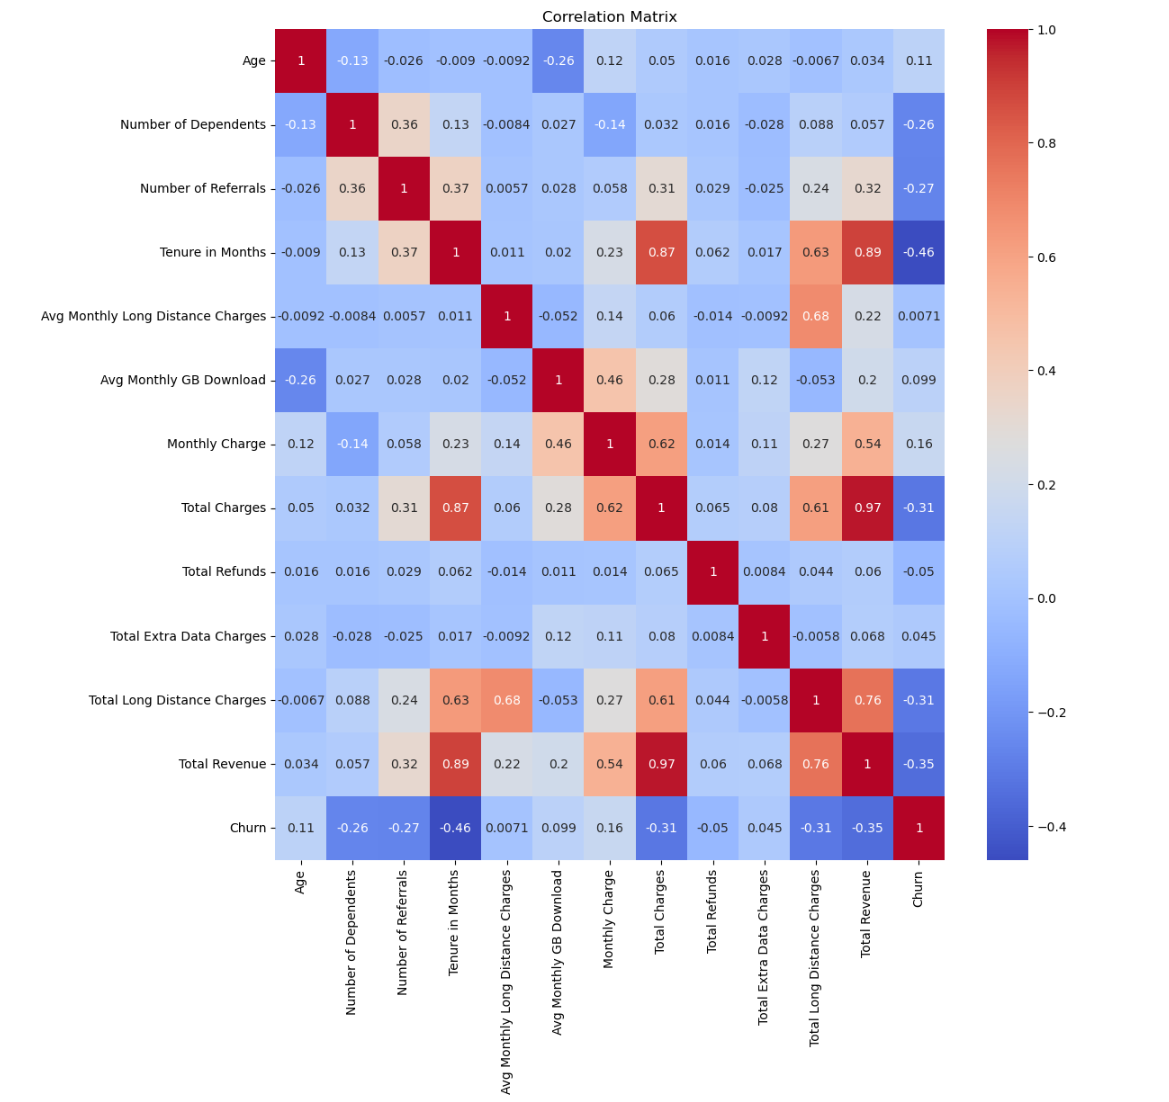

Based on above presented results, we will choose following variables for prediction of churn: **Tenure in Months**, **Monthly Charge** and **Number of Dependents**.

<a id='final_selection'></a>
## 4.3 Final Feature Selection

In [26]:
# drop unnecessary columns
X = data.drop(columns=['Churn','Gender', 'Phone Service', 'Multiple Lines', 'Total Charges', 'Age', 'Avg Monthly Long Distance Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Number of Referrals', 'Customer Status', 'Avg Monthly GB Download'])

In [27]:
# remaining columns for the prediction
X.columns

Index(['Married', 'Number of Dependents', 'Tenure in Months', 'Offer',
       'Internet Service', 'Internet Type', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge'],
      dtype='object')

<a id='feature_encoding'></a>
# 5. Feature Encoding

In [29]:
# divide the columns based on feature encoding method that will be applied
columns_label_encoding = ['Married', 'Internet Service', 'Paperless Billing']
columns_feature_scaling = ['Number of Dependents', 'Tenure in Months', 'Monthly Charge']
columns_one_hot_encoding = ['Offer', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Payment Method']

# reordering the columns
X = X[['Offer', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Payment Method','Married', 'Internet Service', 'Paperless Billing', 'Number of Dependents', 'Tenure in Months', 'Monthly Charge']]



# save the order of columns
import joblib
joblib.dump(list(X.columns),'column_names.pkl')

['column_names.pkl']

<a id='label_encoding'></a>
## 5.1 Label Encoding

**Label Encoding** converts categorical variables into numerical ones by assigning a unique numerical value to each category in a categorical variable.

In [31]:
X[columns_label_encoding] = X[columns_label_encoding].apply(lambda x: x.map({'Yes': 1, 'No':0}))

<a id='one_hot'></a>
## 5.2 One-Hot Encoding

**One-Hot Encoding** creates a new binary column for each value of the categorical variable. The new column contains zeros and ones indicating the absence or presence of the category in the data. 

In [33]:
# also working
# data_encoded = pd.get_dummies(X, columns = columns_one_hot_encoding)
# data_encoded.head()

In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), columns_one_hot_encoding)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [35]:
print(X[:3, :])

[[ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   1.   1.   0.   0.
   1.   0.   0.   0.   0.   1.   0.   1.   0.   0.   1.   0.   1.   1.
   1.   0.   9.  65.6]
 [ 1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   1.
   0.   0.   1.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   1.
   0.   0.   1.   1.   0.   0.   1.   0.   0.   0.   1.   0.   0.   1.
   0.   0.   9.  -4. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   1.   0.   1.   0.   0.   1.
   0.   0.   0.   0.   1.   1.   0.   0.   1.   0.   0.   1.   0.   0.
   1.   0.   0.   0.   0.   1.   1.   0.   0.   1.   0.   0.   0.   1.
   1.   0.   4.  73.9]]


In [36]:
# transform y to numpy array
y = np.array(y)

<a id='train_test'></a>
# 6. Splitting the dataset into the Training set and Test set

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

<a id='feature_scaling'></a>
# 7. Feature Scaling

**Feature scaling** is a preprocessing technique that is used to standardize or normalize the range of independent variables of data. The goal of feature scaling is to bring all the features to a similar scale without distorting the differences in the values. This is important because many machine learning algorithms perform better when the input features are on a similar scale. Feature scaling helps prevent features with larger scales from dominating those with smaller scales during the training process.

In this project, we are going to apply **Min-Max Scaling (Normalization)** to the following columns: **Number of Dependents, Tenure in Months, Monthly Charge**.

In [40]:
# normalization
# applied to the last 3 columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[:, -3:] = scaler.fit_transform(X_train[:, -3:])
X_test[:, -3:] = scaler.transform(X_test[:, -3:])

<a id='modelling'></a>
# 8. Modelling

In this section, we are going to compare the performance of particular models with default hyperparameters.

As we are dealing with **imbalanced dataset**, therefore:
- the accuracy is not a good metric because of the accuracy paradox,
- instead we check **f1-score** and **Cohen's Cappa score**, 
- we need to **focus on minor class** (with **label 1**)


Let's remind that:
- **f1 score** is defined as a **harmonic mean of the precision and recall**
- **high precision** indicates a **low number of False Positives** (FP)
- **high recall** indicates a **low number of False Negatives** (FN)
- **Cohen's Cappa score** measures agreement between two dependent categorical samples

In [43]:
# imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report, cohen_kappa_score, ConfusionMatrixDisplay

In [44]:
def create_models(random_state=101):
    '''
    Create a list of machine learning models.
            Parameters:
                    random_state (integer): random state of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=random_state, max_iter=101)))
    models.append(('support_vector_machine', SVC(random_state=random_state)))
    models.append(('random_forest', RandomForestClassifier(random_state=random_state)))
    
    return models

# create a list with all the algorithms we are going to assess
models = create_models()

In [45]:
default_hyperparameters = {}
confusion_matrices = {}
for name, model in models:
    # fit the model with the training set
    model.fit(X_train, y_train)
    
    # make the predictions with the testing set
    y_pred = model.predict(X_test)
    
    # store hyperparameters
    default_hyperparameters[name] = model.get_params(deep=True)
    
    # count and store confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    confusion_matrices[name] = cm
    
    # cohen kappa score
    kappa = cohen_kappa_score(y_test, y_pred)
   
    # print Cohen's kappa score and other metrics for each model
    print('************** {} **************\n'.format(name))
    print("Cohen's kappa score: {}\n".format(kappa))
    print(classification_report(y_test,y_pred)) 


************** k_nearest_neighbors **************

Cohen's kappa score: 0.5510911766767117

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       940
           1       0.68      0.69      0.68       378

    accuracy                           0.82      1318
   macro avg       0.77      0.78      0.78      1318
weighted avg       0.82      0.82      0.82      1318

************** logistic_regression **************

Cohen's kappa score: 0.559626009833166

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       940
           1       0.70      0.67      0.68       378

    accuracy                           0.82      1318
   macro avg       0.78      0.78      0.78      1318
weighted avg       0.82      0.82      0.82      1318

************** support_vector_machine **************

Cohen's kappa score: 0.5672667888609098

              precision    recall  f1-score   support

           0 

Based on above we can see that **Random Forest** has the largest value of Cohen's kappa and f1-score for both labels 0 and 1. Even though we won't use this model, because it has the lowest recall value for label 1 (which indicates high number of False Negatives).

Comparing **Logistic Regression** to SVM we can come to conclusion that **Support Vector Machine** is more sufficient.

Finally, **K-Nearest Neighbors**, comparing to **Support Vector Machine**, has largest recall value (for label 1), but all remaining recall and precision values are lower. Also based on comparation of confusion matrices (below), we will choose **Support Vector Machine** model. 

In [ ]:
cm = confusion_matrices["k_nearest_neighbors"] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("KNN")
plt.show()

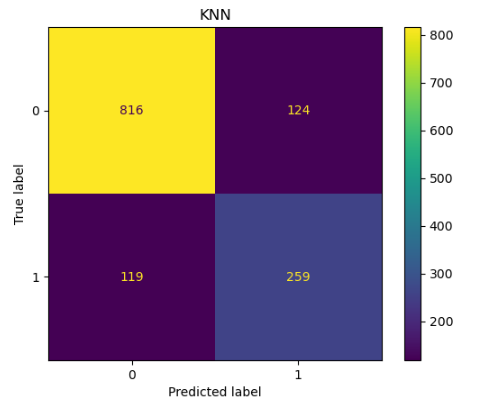

In [ ]:
cm = confusion_matrices["support_vector_machine"] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("SVM")
plt.show()

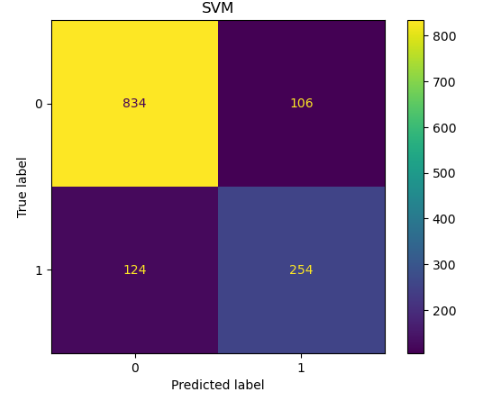

<a id='hyperparameter'></a>
# 9. Hyperparameter tuning

The selection of hyperparameters consists of testing the performance of the model against different combinations of hyperparameters, selecting those that perform best according to a chosen metric and a validation method.

## Support Vector Machine

In [51]:
default_hyperparameters['support_vector_machine']

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 101,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [52]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf','poly','sigmoid']},
 ]

In [53]:
from sklearn.model_selection import GridSearchCV
svc_model = SVC(random_state=101)
grid_model = GridSearchCV(svc_model,param_grid=param_grid)
grid_model.fit(X_train,y_train)

GridSearchCV(estimator=SVC(random_state=101),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf', 'poly', 'sigmoid']}])

In [54]:
grid_model.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [55]:
y_pred = grid_model.predict(X_test)

In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       940
           1       0.71      0.70      0.70       378

    accuracy                           0.83      1318
   macro avg       0.79      0.79      0.79      1318
weighted avg       0.83      0.83      0.83      1318



In [ ]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

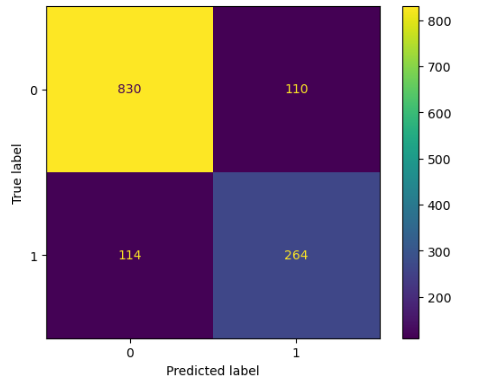

We can see that hyperparameter tuning hasn't improved the model performace very much, but it decreased the number of customers predicted to stay who actually left (False Negative), which was desired.

<a id='final_model'></a>
# 10. Final model

We found the **best** combination of **hyperparameters for Support Vector Machines**:
- C = 1000
- gamma = 0.001
- kernel = rbf
- random_state=101

Now we need to **retrain** our model **on the whole dataset** (X,y). Before that we need to apply the **feature scaling** on the whole feature matrix X.

In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[:, -3:] = scaler.fit_transform(X[:, -3:])

In [62]:
final_model = SVC(random_state=101, C=1000, gamma=0.001, kernel='rbf')
final_model.fit(X,y)
y_pred = final_model.predict(X)

In [63]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4720
           1       0.74      0.70      0.72      1869

    accuracy                           0.85      6589
   macro avg       0.81      0.80      0.81      6589
weighted avg       0.84      0.85      0.84      6589



In [ ]:
cm = confusion_matrix(y,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

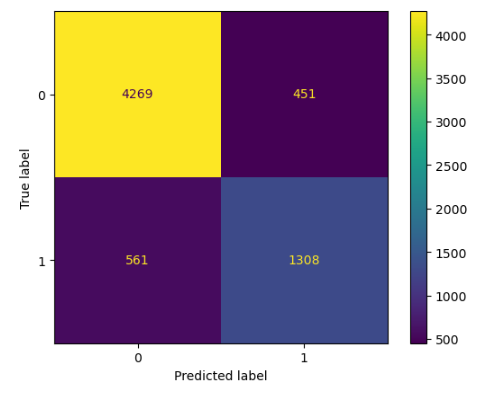

### Save the final model

In [66]:
import joblib

# save the scaler for the feature scaling
joblib.dump(scaler,'scaler.pkl')

# save the column transformer for one hot encoding
joblib.dump(ct,'column_transformer.pkl')

# save the final model
joblib.dump(final_model,'final_model.pkl')

['final_model.pkl']

### Testing the final model

In [141]:
input = {"Gender": "Male", 'Age': 50, 'Married': "No", 'Number of Dependents': 0,
       'Number of Referrals': 0, 'Tenure in Months': 4, 'Offer': "No Offer", 'Phone Service': "Yes",
       'Avg Monthly Long Distance Charges': 33.65, 'Multiple Lines': "No",
       'Internet Service': "Yes", 'Internet Type': "Fiber Optic", 'Avg Monthly GB Download': 30.0,
       'Online Security': "No", 'Online Backup': "No", 'Device Protection Plan': "Yes",
       'Premium Tech Support': "No", 'Streaming TV': "No", 'Streaming Movies': "No",
       'Streaming Music': "No", 'Unlimited Data': "Yes", 'Contract': "Month-to-Month", 'Paperless Billing': "Yes",
       'Payment Method': "Bank Withdrawal", 'Monthly Charge': 73.9, 'Total Charges':280.85, 'Total Refunds': 0.00,
       'Total Extra Data Charges': 0, 'Total Long Distance Charges': 134.60,
       'Total Revenue': 415.45 }

In [143]:
customer = pd.Series(input, index=input.keys())
customer

Gender                                          Male
Age                                               50
Married                                           No
Number of Dependents                               0
Number of Referrals                                0
Tenure in Months                                   4
Offer                                       No Offer
Phone Service                                    Yes
Avg Monthly Long Distance Charges              33.65
Multiple Lines                                    No
Internet Service                                 Yes
Internet Type                            Fiber Optic
Avg Monthly GB Download                         30.0
Online Security                                   No
Online Backup                                     No
Device Protection Plan                           Yes
Premium Tech Support                              No
Streaming TV                                      No
Streaming Movies                              

In [145]:
customer = pd.DataFrame(customer).transpose()
customer

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,Male,50,No,0,0,4,No Offer,Yes,33.65,No,Yes,Fiber Optic,30.0,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,73.9,280.85,0.0,0,134.6,415.45


In [149]:
col_names = joblib.load('final_model/column_names.pkl')
f_scaler = joblib.load('final_model/scaler.pkl')
col_trans = joblib.load('final_model/column_transformer.pkl')
loaded_model = joblib.load('final_model/final_model.pkl')

In [151]:
# reorder columns
customer=customer[col_names]
customer

,Offer,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Payment Method,Married,Internet Service,Paperless Billing,Number of Dependents,Tenure in Months,Monthly Charge
0,No Offer,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Bank Withdrawal,No,Yes,Yes,0,4,73.9


In [153]:
# apply label encoding
customer[columns_label_encoding] = customer[columns_label_encoding].apply(lambda x: x.map({'Yes': 1, 'No':0}))
customer

,Offer,Internet Type,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Payment Method,Married,Internet Service,Paperless Billing,Number of Dependents,Tenure in Months,Monthly Charge
0,No Offer,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Month-to-Month,Bank Withdrawal,0,1,1,0,4,73.9


In [155]:
# apply one-hot encoding
customer = np.array(col_trans.transform(customer))
customer

array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0,
        1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,
        0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,
        0.0, 0, 1, 1, 0, 4, 73.9]], dtype=object)

In [157]:
# apply feature scaling on the last 3 columns
customer[:, -3:] = f_scaler.transform(customer[:, -3:])

In [159]:
customer

array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0,
        1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,
        0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,
        0.0, 0, 1, 1, 0.0, 0.04225352112676056, 0.6516504854368932]],
      dtype=object)

In [161]:
# make prediction using the model
prediction = loaded_model.predict(customer)
print(prediction)

[1]


In [163]:
if prediction == 1:
    print("Customer is predicted to churn.")
else:
    print("Customer is predicted to stay.")

Customer is predicted to churn.
